In [2]:
# I install PyTorch explicitly to ensure version consistency
!pip install -q torch torchvision torchaudio

# so I install torch-geometric to enable graph neural network modules.
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.2 MB/s eta 0:00:00


In [3]:
# Core PyTorch + PyG components
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# Utilities for splitting and visualization
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# I use the MUTAG dataset, a standard graph classification benchmark.
# Each graph represents a molecule, and the task is binary classification.

dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# I split the dataset into train and test sets.
train_dataset, test_dataset = train_test_split(
    dataset, test_size=0.2, random_state=42
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Number of graphs: {len(dataset)}")
print(f"Node features: {dataset.num_node_features}")
print(f"Classes: {dataset.num_classes}")

Number of graphs: 188
Node features: 7
Classes: 2


Processing...
Done!


In [5]:
# I define a GCN model where I can vary the number of layers.
# This allows me to directly study the effect of depth on performance
# and representation quality.

class DeepGCN(torch.nn.Module):
    def __init__(self, num_layers, hidden_dim=64):
        super().__init__()
        self.convs = torch.nn.ModuleList()

        # First layer maps input features to hidden space
        self.convs.append(GCNConv(dataset.num_node_features, hidden_dim))

        # Additional layers keep the same hidden dimension
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        self.lin = torch.nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self, data, return_embeddings=False):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Message passing layers
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))

        # If I want to analyze node embeddings directly,
        # I return them before pooling.
        if return_embeddings:
            return x

        # Global pooling makes the model permutation invariant at graph level.
        x = global_mean_pool(x, batch)
        return self.lin(x)

In [6]:
# Standard training loop
def train(model, optimizer):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()

# Evaluation function
def test(model):
    model.eval()
    correct = 0
    for data in test_loader:
        out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(test_dataset)

In [7]:
# Oversmoothing implies that node representations become similar.
# To quantify this, I compute the average variance across embedding dimensions.

def embedding_variance(model, loader):
    model.eval()
    variances = []

    for data in loader:
        embeddings = model(data, return_embeddings=True)
        var = torch.var(embeddings, dim=0).mean().item()
        variances.append(var)

    return sum(variances) / len(variances)

In [8]:
# Another way to measure oversmoothing is to compute
# average pairwise cosine similarity between node embeddings.
# Higher similarity indicates representation collapse.

def average_cosine_similarity(model, loader):
    model.eval()
    sims = []

    for data in loader:
        embeddings = model(data, return_embeddings=True)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        sim_matrix = torch.mm(embeddings, embeddings.t())
        sims.append(sim_matrix.mean().item())

    return sum(sims) / len(sims)

In [9]:
# I use PCA to visualize global variance structure.
# Since oversmoothing reduces variance, PCA should reflect collapse.

def visualize_embeddings(model, loader, title):
    model.eval()

    for data in loader:
        embeddings = model(data, return_embeddings=True).detach().numpy()
        break

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    plt.figure(figsize=(5,5))
    plt.scatter(reduced[:,0], reduced[:,1], alpha=0.7)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


Training 2-Layer GCN
2-Layer Accuracy: 0.8684
2-Layer Embedding Variance: 0.023516
2-Layer Avg Cosine Similarity: 0.531069


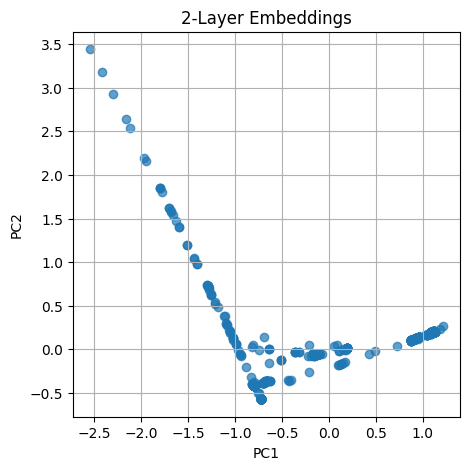


Training 4-Layer GCN
4-Layer Accuracy: 0.8158
4-Layer Embedding Variance: 0.070313
4-Layer Avg Cosine Similarity: 0.373058


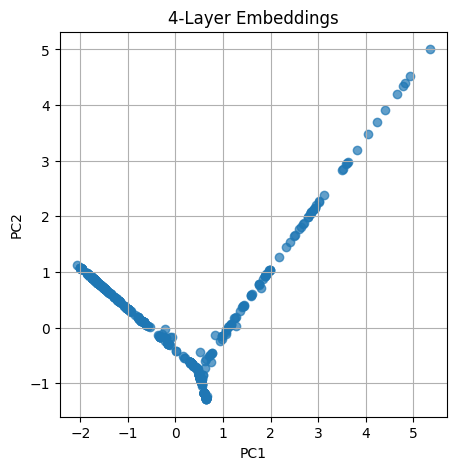


Training 6-Layer GCN
6-Layer Accuracy: 0.8158
6-Layer Embedding Variance: 0.124769
6-Layer Avg Cosine Similarity: 0.582970


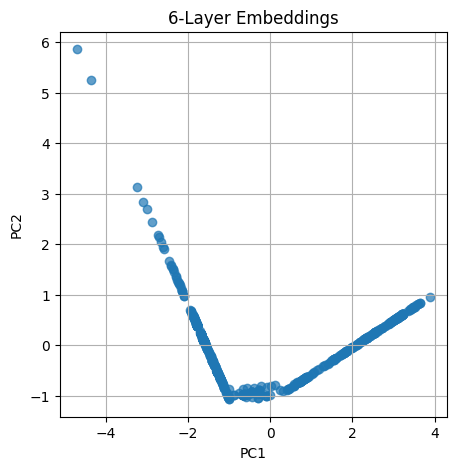


Training 8-Layer GCN
8-Layer Accuracy: 0.8158
8-Layer Embedding Variance: 0.057415
8-Layer Avg Cosine Similarity: 0.513679


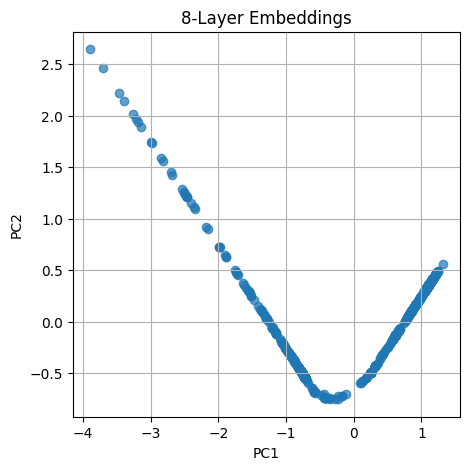


Training 10-Layer GCN
10-Layer Accuracy: 0.8421
10-Layer Embedding Variance: 0.082516
10-Layer Avg Cosine Similarity: 0.567515


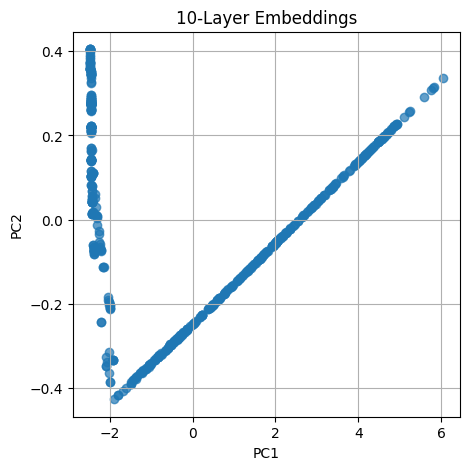


Final Summary Across Depths:
Layers: 2 | Accuracy: 0.8684 | Variance: 0.023516 | CosSim: 0.531069
Layers: 4 | Accuracy: 0.8158 | Variance: 0.070313 | CosSim: 0.373058
Layers: 6 | Accuracy: 0.8158 | Variance: 0.124769 | CosSim: 0.582970
Layers: 8 | Accuracy: 0.8158 | Variance: 0.057415 | CosSim: 0.513679
Layers: 10 | Accuracy: 0.8421 | Variance: 0.082516 | CosSim: 0.567515


In [28]:
# I now compare models of increasing depth to study how representation
# structure and performance evolve as message-passing layers grow deeper.

results = []

for layers in [2, 4, 6, 8, 10]:
    print(f"\nTraining {layers}-Layer GCN")

    # Initialize model with specified depth
    model = DeepGCN(num_layers=layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # I train each model for a fixed number of epochs
    # to keep the comparison controlled across depths.
    for epoch in range(50):
        train(model, optimizer)

    # Evaluate performance and representation metrics
    acc = test(model)
    var = embedding_variance(model, test_loader)
    cos = average_cosine_similarity(model, test_loader)

    print(f"{layers}-Layer Accuracy: {acc:.4f}")
    print(f"{layers}-Layer Embedding Variance: {var:.6f}")
    print(f"{layers}-Layer Avg Cosine Similarity: {cos:.6f}")

    # Visualize node embeddings using PCA
    visualize_embeddings(model, test_loader, f"{layers}-Layer Embeddings")

    results.append((layers, acc, var, cos))


# Final structured summary for clarity
print("\nFinal Summary Across Depths:")
for r in results:
    print(f"Layers: {r[0]} | Accuracy: {r[1]:.4f} | Variance: {r[2]:.6f} | CosSim: {r[3]:.6f}")

## Depth Analysis

In this study, I investigated how increasing depth affects performance and representation structure in Graph Convolutional Networks (GCNs), evaluating models from 2 to 10 layers.

The results do not exhibit a simple monotonic trend. Test accuracy was highest at 2 layers, decreased at intermediate depths, and partially recovered at 10 layers. This suggests that increasing depth does not deterministically degrade or improve performance in this setting.

Embedding variance fluctuated across depths rather than decreasing consistently. While variance increased substantially at certain depths, it decreased at others. This indicates that representation dispersion and structural mixing interact in non-linear ways.

Cosine similarity values also showed a non-monotonic pattern. Although deeper models exhibited increased alignment at some depths, the trend was not consistent across all depths.

Overall, these findings suggest that oversmoothing is not an inevitable or strictly monotonic consequence of increasing depth in small-scale graph classification tasks. Instead, representation dynamics appear to depend on dataset structure, graph size, feature dimensionality, and optimization effects.

This experiment highlights that theoretically motivated phenomena such as oversmoothing may manifest conditionally rather than universally in practical implementations.